In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image
import numpy as np
import json

In [351]:
class weather():
    def __init__(self, weather_img = "weather.png" , weather_json = "weather.json"):
        self.weather_matrix = self.to_matrix(weather_img).astype(np.int8)
        
        self.bottom_right, self.top_left = self.coordinates(weather_json)
        
    def coordinates(self, weather_json):
        weather_coordinates = json.load(open('weather.json'))
        
        return [weather_coordinates["bottom_right"]["latitude"], weather_coordinates["bottom_right"]["longitude"]] \
                 , [ weather_coordinates["top_left"]["latitude"], weather_coordinates["top_left"]["longitude"]]
    def br(self):
        return self.bottom_right
    def tl(self):
        return self.top_left
    
    def to_matrix(self, weather_img):
        weather_matrix = np.array(matplotlib.image.imread(weather_img)[: ,: , 1])
        
        un = np.unique(weather_matrix[0], axis = 0)
        
        def map_green(x):
            return (np.isclose(x , un[1]))
        def map_yellow(x):
            return (np.isclose(x , un[2]))
        
        return weather_matrix*0 + map_green(weather_matrix)*1 + map_yellow(weather_matrix)*2
    def wmatrix(self):
        return self.weather_matrix
        

In [352]:
w = weather()

In [353]:
w.br()

[21.94, -67.5]

In [354]:
w.tl()

[55.78, -135.0]

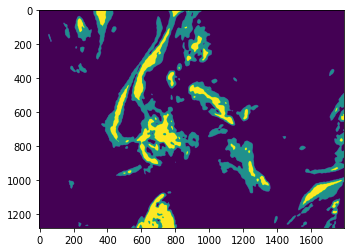

In [355]:
plt.imshow(w.wmatrix())